In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import itertools
import networkx as nx 
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle
from abstract_udmis import AbstractUDMIS

%matplotlib inline
sns.set(rc={'figure.figsize':(15,15)})

## Read Sample Data & Extract Occupations Distribution

In [3]:
task_2_data_df = pd.read_csv("task2_data.dat", delimiter=' ', header=None)
task_2_data_df.columns = ['Occupation']
task_2_data_df['Occupation_bin'] = task_2_data_df['Occupation'].apply(lambda x: format(int(x), '06b'))

## Evaluate Solution Occupations & Plot their distributions

In [5]:
occupations_top_df = task_2_data_df['Occupation_bin'].value_counts()[task_2_data_df['Occupation_bin'].value_counts()> 1000]
occupations_top_df.name = 'Occupations'
occupations_top_df

011100    2899
010101    2851
110100    2765
Name: Occupation_bin, dtype: int64

Text(0.5, 1.0, 'Solution Occupations Distribution - Quantum Simulation')

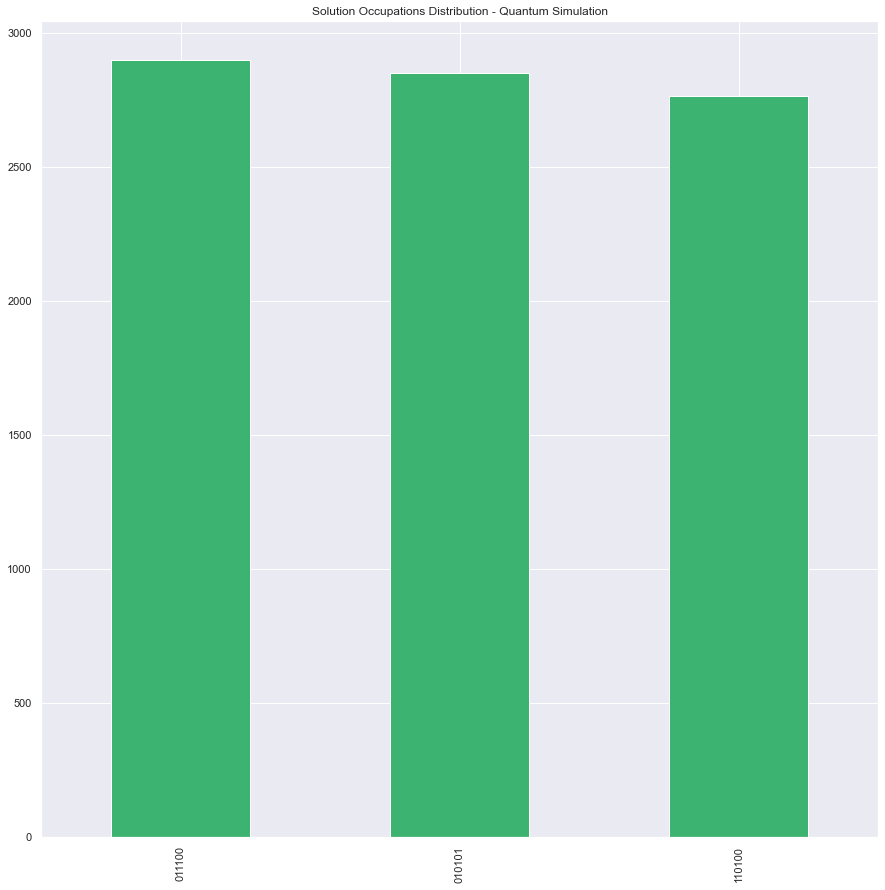

In [11]:
fig = occupations_top_df.plot(kind='bar', color='mediumseagreen')
fig.set_title('Solution Occupations Distribution - Quantum Simulation')

## Plot Solution Occupations

In [17]:
u = 1.35
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

In [ ]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges

    def get_edges(self):
        edges = list()
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges.append([i,j])
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)

6


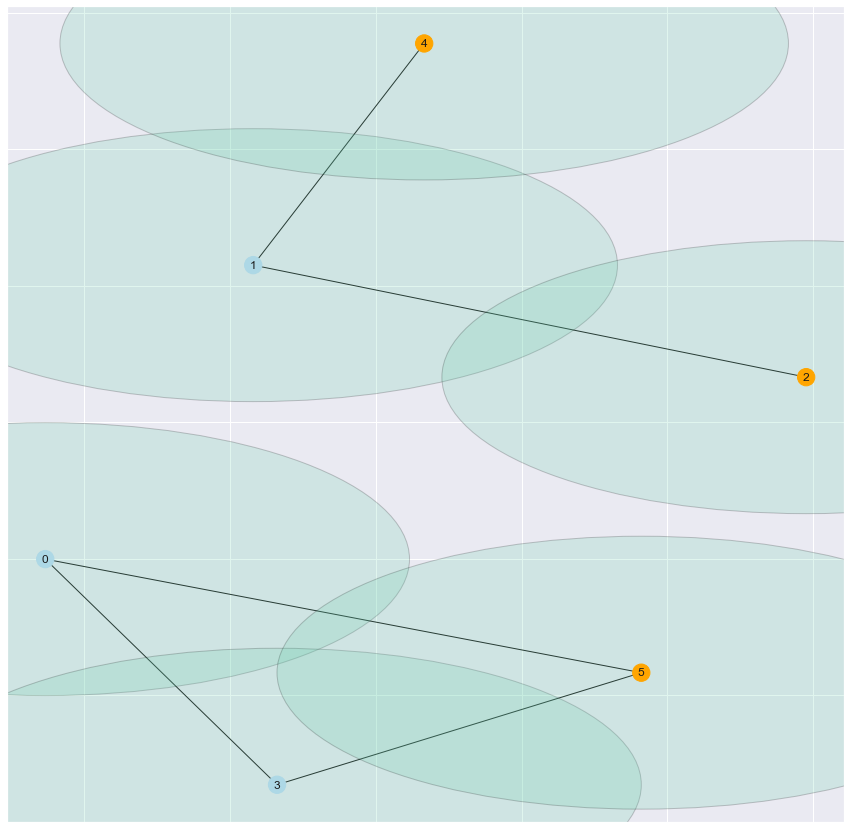

In [22]:
udmis = UDMIS(u, graph)
vertices = list(range(udmis.num_vertices))
G = nx.Graph() 
G.add_nodes_from(vertices)
edge_list = udmis.get_edges()
for edge in edge_list:
    G.add_edge(edge[0],edge[1])
    
color_map = list()

for node in occupations_top_df.index[2][::-1]:
    if node == '0':
        color_map.append('lightblue')
    else: 
        color_map.append('orange')

pos = {v:graph[v] for v in vertices}
fig, ax = plt.subplots(1, 1)

ax1 = nx.draw_networkx(G, pos=pos, with_labels=True, node_color=color_map)
for node in G.nodes():
    ax.add_artist(Circle(xy=pos[node], radius=.5, 
    facecolor='mediumaquamarine', alpha=0.2, edgecolor='black'))
# nxv.render(G, style)
plt.grid('on')
plt.show()